<a href="https://colab.research.google.com/github/vitsiupia/projektPython/blob/main/prosty_model_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pobierzmy dane i zobaczmy jak wyglądają
!wget 'https://github.com/vitsiupia/projektPython/raw/main/meetings_split.zip'

--2023-05-17 08:53:15--  https://github.com/vitsiupia/projektPython/raw/main/meetings_split.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vitsiupia/projektPython/main/meetings_split.zip [following]
--2023-05-17 08:53:16--  https://raw.githubusercontent.com/vitsiupia/projektPython/main/meetings_split.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1027422 (1003K) [application/zip]
Saving to: ‘meetings_split.zip’

meetings_split.zip  100%[===================>]   1003K  --.-KB/s    in 0.03s   

2023-05-17 08:53:16 (35.7 MB/s) - ‘meetings_split.zip’ saved [1027422/1027422]



In [2]:
import zipfile
with zipfile.ZipFile('meetings_split.zip', 'r') as zip:
  zip.extractall()

## Wizualizacja danych

Zobaczmy z czym pracujemy

In [3]:
import os
import random
import textwrap

def visualize_data(folder):
    # Sprawdzenie czy folder istnieje
    if not os.path.exists(folder):
        print(f"Folder '{folder}' nie istnieje.")
        return

    transcripts = []
    summaries = []

    # Przejście przez pliki w folderze
    for filename in os.listdir(folder):
        if filename.endswith('.transcript.txt'):
            transcripts.append(filename)
        elif filename.endswith('.abssumm.txt'):
            summaries.append(filename)

    # Sprawdzenie czy istnieją zarówno transkrypty jak i podsumowania
    if not transcripts or not summaries:
        print("Brak zarówno transkryptów jak i podsumowań w folderze.")
        return

    # Losowe wybranie pliku
    random_file = random.choice(transcripts + summaries)

    # Wybieranie transkryptu i podsumowania na podstawie losowego pliku
    if random_file.endswith('.transcript.txt'):
        transcript_file = random_file
        summary_file = random_file.replace('.transcript.txt', '.abssumm.txt')
    else:
        summary_file = random_file
        transcript_file = random_file.replace('.abssumm.txt', '.transcript.txt')

    # Odczytanie treści transkryptu
    with open(os.path.join(folder, transcript_file), 'r', encoding='utf-8') as file:
        transcript_text = file.read()

    # Odczytanie treści podsumowania
    with open(os.path.join(folder, summary_file), 'r', encoding='utf-8') as file:
        summary_text = file.read()

    # Wyświetlanie transkryptu
    print(f"Transkrypt {transcript_file.split('.')[0]}:")
    lines = textwrap.wrap(transcript_text, width=80)
    for line in lines:
        print(line)

    print()

    # Wyświetlanie podsumowania
    print("Podsumowanie:")
    lines = textwrap.wrap(summary_text, width=80)
    for line in lines:
        print(line)

In [4]:
visualize_data('meetings_split/train')

Transkrypt TS3011b:
time cup coffee get cup coffee well work time either think yes excuse still
right thing well changes design requirements changes method also basically
device send messages tv set easy way sending pulses infrared light tv set well
th tried implement picture hardly readable see well theres energy source
basically connected three things user interface connected chip connected sender
generates messages using infrared light sent receiver thats basically idea
theres little picture imagination device look look found usually kind things
consist battery infrared diode buttons chips circuit board thats cased together
nothing almost every piece equipment every piece every tv set controlled
infrared exceptions infrared controls luxury remote controls lithium buttons
think thats w yes little little bit fancy also maybe consider basic scheme
things implemented basically theres one chip buttons connected buttons lit whole
thing transmitted infrared li diode power source thats basi

## Tworzenie prostego modelu NLP

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model

def create_text_to_text_model(input_vocab_size, output_vocab_size, input_max_len, output_max_len, hidden_units):
    # Warstwa kodująca (Encoder)
    encoder_input = Input(shape=(input_max_len,))
    encoder_embedding = Embedding(input_vocab_size, hidden_units, mask_zero=True)(encoder_input)
    encoder_lstm = LSTM(hidden_units, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_state = [state_h, state_c]

    # Warstwa dekodująca (Decoder)
    decoder_input = Input(shape=(output_max_len,))
    decoder_embedding = Embedding(output_vocab_size, hidden_units, mask_zero=True)(decoder_input)
    decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
    decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_state)
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    decoder_output = decoder_dense(decoder_output)

    # Tworzenie modelu
    model = Model([encoder_input, decoder_input], decoder_output)
    return model

# Przykładowe użycie
input_vocab_size = 3000
output_vocab_size = 2000
input_max_len = 3900
output_max_len = 220
hidden_units = 256

model = create_text_to_text_model(input_vocab_size, output_vocab_size, input_max_len, output_max_len, hidden_units)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3900)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 220)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 3900, 256)    768000      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 220, 256)     512000      ['input_2[0][0]']                
                                                                                              

## Przygotowanie danych do ich wejścia do modelu

In [6]:
# Ścieżki do folderu z danymi treningowymi i walidacyjnymi
train_data_dir = "meetings_split/train"
val_data_dir = "meetings_split/val"

In [7]:
import glob
import os

train_transcripts_list = glob.glob("meetings_split/train/*.txt")
train_transcripts_list = [t for t in train_transcripts_list if ".abssumm" not in t]
train_summaries_list = [t.replace('.transcript', '.abssumm') for t in train_transcripts_list]

val_transcripts_list = glob.glob("meetings_split/val/*.txt")
val_transcripts_list = [t for t in val_transcripts_list if ".abssumm" not in t]
val_summaries_list = [t.replace('.transcript', '.abssumm') for t in val_transcripts_list]

# Wyświetlenie ścieżek do plików, aby sprawdzić poprawność
print(train_transcripts_list)
print(train_summaries_list)
print(val_transcripts_list)
print(val_summaries_list)

['meetings_split/train/ES2012a.transcript.txt', 'meetings_split/train/ES2007d.transcript.txt', 'meetings_split/train/ES2016d.transcript.txt', 'meetings_split/train/TS3008d.transcript.txt', 'meetings_split/train/TS3004a.transcript.txt', 'meetings_split/train/TS3012d.transcript.txt', 'meetings_split/train/TS3003c.transcript.txt', 'meetings_split/train/ES2016b.transcript.txt', 'meetings_split/train/IS1002c.transcript.txt', 'meetings_split/train/TS3007a.transcript.txt', 'meetings_split/train/IS1006d.transcript.txt', 'meetings_split/train/IS1000a.transcript.txt', 'meetings_split/train/TS3011b.transcript.txt', 'meetings_split/train/TS3011c.transcript.txt', 'meetings_split/train/TS3008b.transcript.txt', 'meetings_split/train/TS3010a.transcript.txt', 'meetings_split/train/TS3005c.transcript.txt', 'meetings_split/train/ES2012d.transcript.txt', 'meetings_split/train/ES2011d.transcript.txt', 'meetings_split/train/ES2006b.transcript.txt', 'meetings_split/train/IS1005a.transcript.txt', 'meetings_sp

In [8]:
import numpy as np

# Funkcja do odczytywania zawartości plików tekstowych
def read_text_files(file_paths):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read().strip()
            texts.append(text)
    return texts

# Odczytanie zawartości plików train_transcripts i train_summaries
train_transcripts_texts = read_text_files(train_transcripts_list)
train_summaries_texts = read_text_files(train_summaries_list)

# Odczytanie zawartości plików val_transcripts i val_summaries
val_transcripts_texts = read_text_files(val_transcripts_list)
val_summaries_texts = read_text_files(val_summaries_list)

# Tworzenie tensorów dla train_transcripts i train_summaries
train_transcripts_tensor = np.array([train_transcripts_texts, train_summaries_texts]).T

# Tworzenie tensorów dla val_transcripts i val_summaries
val_transcripts_tensor = np.array([val_transcripts_texts, val_summaries_texts]).T


In [9]:
train_transcripts_tensor[0]

array(['names andrew market research person meeting project creating new remote control ill presenting information statistics people want want get new design people want fashion point view practicality point view badger got nice contrast black white feel theyre underdog kind status theyre make mobile phones tv remotes make tv remotes think lot time remotes come tv players tvs dv players arent area thats put lot effort theyre boring plain making stylish remote control would easily put us one step ahead current competition something looks looks doesnt look remote control want something looks something makes think whats pen doesnt really look pen makes think sorry thats bit vague suppose suppose thats marketing make make people aware product well mouse idea could remote piece plastic big rubber buttons sticking press whereas want could flat buttons kind almost subtle instead raised device push device see mouse button suppose easily would good especially try sell two million sorry four mil

## Kompilacja i trenowanie modelu

In [10]:
# Jak duży zrobić padding?
def find_longest_sequence(transcripts, summaries):
    max_transcript_length = 0
    max_summary_length = 0

    for i in range(len(transcripts)):
        with open(transcripts[i], 'r', encoding='utf-8') as t_file:
            transcript = t_file.read().strip()
        with open(summaries[i], 'r', encoding='utf-8') as s_file:
            summary = s_file.read().strip()

        transcript_length = len(transcript.split())
        summary_length = len(summary.split())

        if transcript_length > max_transcript_length:
            max_transcript_length = transcript_length

        if summary_length > max_summary_length:
            max_summary_length = summary_length

    return max_transcript_length, max_summary_length

# Wywołanie funkcji dla Twoich danych
max_transcript_length, max_summary_length = find_longest_sequence(train_transcripts_list, train_summaries_list)

print("Najdłuższy transkrypt ma", max_transcript_length, "słów.")
print("Najdłuższe podsumowanie ma", max_summary_length, "słów.")

Najdłuższy transkrypt ma 3870 słów.
Najdłuższe podsumowanie ma 201 słów.


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Inicjalizacja tokenizera
tokenizer = Tokenizer()

# Dopasowanie tokenizera do tekstów transkryptów i podsumowań
texts = np.concatenate([train_transcripts_tensor[:, 0], train_transcripts_tensor[:, 1]])
tokenizer.fit_on_texts(texts)

# Przekształcenie tekstów na sekwencje indeksów tokenów
train_transcripts_sequences = tokenizer.texts_to_sequences(train_transcripts_tensor[:, 0])
train_summaries_sequences = tokenizer.texts_to_sequences(train_transcripts_tensor[:, 1])
val_transcripts_sequences = tokenizer.texts_to_sequences(val_transcripts_tensor[:, 0])
val_summaries_sequences = tokenizer.texts_to_sequences(val_transcripts_tensor[:, 1])

# Zastosowanie paddingu do sekwencji
max_transcript_length = 3900  # Dostosuj wartość do oczekiwanej maksymalnej długości sekwencji
max_summary_length = 220
train_transcripts_padded = pad_sequences(train_transcripts_sequences, maxlen=max_transcript_length, padding='post')
train_summaries_padded = pad_sequences(train_summaries_sequences, maxlen=max_summary_length, padding='post')
val_transcripts_padded = pad_sequences(val_transcripts_sequences, maxlen=max_transcript_length, padding='post')
val_summaries_padded = pad_sequences(val_summaries_sequences, maxlen=max_summary_length, padding='post')

In [12]:
train_labels = []
val_labels = []

train_labels = train_summaries_padded[:, 0:]
val_labels = val_summaries_padded[:, 0:]

In [13]:
# Kompilacja modelu
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Przetrenowanie modelu
history = model.fit(
    [train_transcripts_padded, train_summaries_padded],
    train_labels,
    validation_data=([val_transcripts_padded, val_summaries_padded], val_labels),
    batch_size=32,
    epochs=10
)

Epoch 1/10
4/4 [==============================] - 20s 1s/step - loss: nan - accuracy: 4.1224e-04 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 2s 494ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 2s 498ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 2s 446ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 2s 505ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 2s 501ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 2s 624ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 8/

#Jeszcze raz od nowa: jak stworzyć waściwy model

Na podstawie https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html.

## Konwertowanie surowego tekstu na dane sekwencyjne

W NLP często pracujemy z danymi tekstowymi reprezentowanymi jako sekwencje słów, liter lub związków wyrazowych. Musimy poznać podstawowe narzędzia do przekształcania pliku tekstowego w sekwencje. Zwykle proces przebiega następująco:

1. Ładujemy tekst jako stringi do pamięci.
2. Dzielimy stringi na tokeny (np. słowa, znaki).
3. Budujemy słownik który wiąże każdy językowy element z jakimś indeksem.
4. Zamieniamy tekst na sekwencje indeksów.

In [14]:
# Importy
import collections
import random
import re
import tensorflow as tf

In [15]:
#!pip install d2l

#from d2l import tensorflow as d2l

### Wczytanie danych

W oryginalnym linku autor pracuje z Machiną Czasu  H. G. Wellsa, ale my będziemy próbowali od razu uporać się z własnym zestawem danych.

In [16]:
# class TimeMachine(d2l.DataModule):
#     """The Time Machine dataset."""
#     def _download(self):
#         fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
#                              '090b5e7e70c295757f55df93cb0a180b9691891a')
#         with open(fname) as f:
#             return f.read()

# data = TimeMachine()
# raw_text = data._download()
# raw_text[:60]

In [17]:
# Skorzystamy z tego, co udało nam się utworzyć wcześniej w tym notatniku

import glob
import os

train_transcripts_list = glob.glob("meetings_split/train/*.txt")
train_transcripts_list = [t for t in train_transcripts_list if ".abssumm" not in t]
train_summaries_list = [t.replace('.transcript', '.abssumm') for t in train_transcripts_list]

val_transcripts_list = glob.glob("meetings_split/val/*.txt")
val_transcripts_list = [t for t in val_transcripts_list if ".abssumm" not in t]
val_summaries_list = [t.replace('.transcript', '.abssumm') for t in val_transcripts_list]

def read_text_files(file_paths):
    texts = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read().strip()
            texts.append(text)
    return texts

# Odczytanie zawartości plików train_transcripts i train_summaries
train_transcripts_texts = read_text_files(train_transcripts_list)
train_summaries_texts = read_text_files(train_summaries_list)

# Odczytanie zawartości plików val_transcripts i val_summaries
val_transcripts_texts = read_text_files(val_transcripts_list)
val_summaries_texts = read_text_files(val_summaries_list)

In [18]:
val_summaries_texts[0]

"The project manager opens the meeting by going over the minutes of the last meeting, detailing the main points of each person's presentation. They do the prototype presentation which includes a model of the remote control. The group discusses this proposed model, approving of the small size and look of it. They goes over finances and are pleased to find that they are well within budget. However, while the marketing expert is doing the product evaulation the group realizes that they neglected to calculate voice recognition into the financing. Their cost had been 8.20 Euros and they have  4.30 left to cover it, so they decide to settle for whatever quality it will buy. They rate their product on its shape, size, color, feel, and functionality. They discuss the project process, talk briefly about adding more features, and one member suggests eliminating a mute buttons and include a diffferent feature. They are happy with the creativity, leadership, and teamwork within the group, and clos

In [19]:
val_summaries_texts[0][:60]

'The project manager opens the meeting by going over the minu'

Pierwszą różnicą z pracą autora a naszą jest to, że on operuje na jednym pliku tekstowym - jednej książce.

###Preprocessing

My akurat możemy to pominąć, ponieważ nasze transkrypty zostały już przetworzone - usunięto wielkie litery, interpunkcję i zbędne słownictwo.

## Tokenizacja
Tokeny to najmniejsze (atomiczne) części tekstu. Każdy time step odpowiada jednemu tokenowi, ale to co dokładnie uznamy za token jest naszym wyborem.



> *For example, we could represent the sentence “Baby needs a new pair of shoes” as a sequence of 7 words, where the set of all words comprise a large vocabulary (typically tens or hundreds of thousands of words). Or we would represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (there are only 256 distinct ASCII characters). Below, we tokenize our preprocessed text into a sequence of characters.*



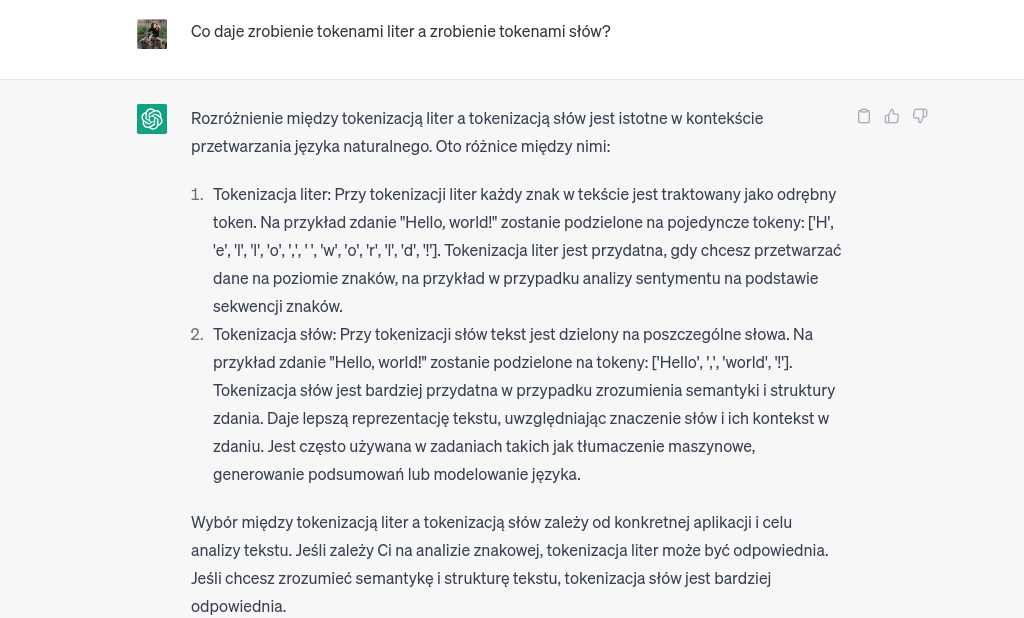

Odpowiedź czatu jest jednoznaczna - robimy tokenizację słów!

In [20]:
# @d2l.add_to_class(TimeMachine)      # Tutaj autor tokenizuje LITERY
# def _tokenize(self, text):
#     return list(text)

# tokens = data._tokenize(text)
# ','.join(tokens[:30])

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
import os
from nltk.tokenize import word_tokenize

import os
from nltk.tokenize import word_tokenize
from shutil import copyfile

def tokenize_files_in_folder(folder_path, output_folder_path):
  # Tworzenie struktury folderów w folderze wyjściowym
    for root, dirs, files in os.walk(folder_path):
      for dir in dirs:
          relative_path = os.path.relpath(os.path.join(root, dir), input_folder_path)
          output_dir_path = os.path.join(output_folder_path, relative_path)
          os.makedirs(output_dir_path, exist_ok=True)
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                input_file_path = os.path.join(root, file)
                
                # Tworzenie ścieżki do pliku wyjściowego w nowym folderze
                relative_path = os.path.relpath(input_file_path, folder_path)
                output_file_path = os.path.join(output_folder_path, relative_path)
                
                # Tworzenie folderów, jeśli nie istnieją
                output_file_dir = os.path.dirname(output_file_path)
                os.makedirs(output_file_dir, exist_ok=True)
                
                with open(input_file_path, "r", encoding="utf-8") as input_file:
                    text = input_file.read()
                    tokens = word_tokenize(text)
                    
                    with open(output_file_path, "w", encoding="utf-8") as output_file:
                        output_file.write(",".join(tokens))
                        
    print(f"Tokenized files saved in {output_folder_path}")

In [37]:
input_folder_path = "meetings_split"
output_folder_path = "meetings_split_tokenized"
tokenize_files_in_folder(input_folder_path, output_folder_path)

Tokenized file saved in meetings_split_tokenized


Teraz wszystkie wyrazy są oddzielone od siebie przecinkiem.

### Słownik słów
Otrzymane tokeny to w dalszym ciągu stringi. Ale jak wiemy, wejściem do modeli uczenia maszynowego muszą być zawsze iliczby (tak samo jak i wyjściem). Zapoznamy się teraz z klasą do tworzenia słowników, które do każdego różnego tokenu dopiszą unikalny indeks. 

Będziemy musieli:
1. Określić ile mamy unikatowych tokenów w naszym korpusie.
2. Przypisać unikalną liczbę do każdego z tych tokenów.

Rzadko występujące słowa są często w tej fazie pomijane dla uproszczenia. 

Kiedy tylko napotkamy token w czasie trenowania lub testowania, który nie był wczęsniej napotkany lub został usunięty ze słownika, reprezentujemy go poprzez token "< unk >", co zaznacza że jest on wartością nieznaną. 

In [38]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']

Teraz musimy utworzyć słownik dla naszego zbioru danych, konwertując sekwencje stringów na listę indeksów. 

> **Note:** Nie tracimy w ten sposób żadnych informacji i możemy z łatwością przekonwertować zbiór danych z powrotem do stanu początkowego. 

In [40]:
def use_vocab_in_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
                    tokens = word_tokenize(text)
                    
                    vocab = Vocab(tokens)
                    indices = vocab[tokens[:10]]
                    words = vocab.to_tokens(indices)
                    
                    print("File:", file_path)
                    print("Indices:", indices)
                    print("Words:", words)


In [42]:
# Użycie Vocab dla ztokenizowanych plików
use_vocab_in_folder(output_folder_path)

### Użycie wszystkiego razem
Teraz włożymy to wszystko do metody build, która zwraca korpus, listę indeksów tokenów i słownik. 